In [1]:
import glob
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
import seaborn as sb
import segmentation_models as sm
import functools as ft
import pandas as pd
import numpy as np

# disable GPU computation
tf.config.set_visible_devices([], 'GPU')

sm.set_framework('tf.keras')
sm.framework()

tf.random.set_seed(1024)
SEED = 100

2021-12-12 00:54:48.195537: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Segmentation Models: using `keras` framework.


2021-12-12 00:54:51.330025: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-12 00:54:51.515170: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-12 00:54:51.515214: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist


In [2]:
def get_image_decode(image, label):
    image = tf.io.read_file(image, "image")
    label = tf.io.read_file(label, "label")

    image = tf.image.decode_image(image)
    label = tf.image.decode_image(label)

    return image, label


# [w, h, c], 448, 448, 3
def decode_crop(image, label):
    image = image[368 // 2 : -(368 // 2), 256 // 2 : -(256 // 2)]
    label = label[368 // 2 : -(368 // 2), 256 // 2 : -(256 // 2)]

    img_array = []
    label_array = []

    for index in range(4 * 8):
        x, y = index // 8, index % 8
        img_array.append(image[448 * x : 448 * (1 + x), 448 * y : 448 * (1 + y)])
        label_array.append(label[448 * x : 448 * (1 + x), 448 * y : 448 * (1 + y)])

    return tf.data.Dataset.from_tensor_slices((img_array, label_array))


def get_mask(image, label):
    labels = []
    labels.append((label[:, :, 0] == 0) & (label[:, :, 1] == 0) & (label[:, :, 2] == 0))
    labels.append(
        (label[:, :, 0] == 128) & (label[:, :, 1] == 0) & (label[:, :, 2] == 0)
    )
    labels.append(
        (label[:, :, 0] == 128) & (label[:, :, 1] == 64) & (label[:, :, 2] == 128)
    )
    labels.append(
        (label[:, :, 0] == 0) & (label[:, :, 1] == 128) & (label[:, :, 2] == 0)
    )
    labels.append(
        (label[:, :, 0] == 128) & (label[:, :, 1] == 128) & (label[:, :, 2] == 0)
    )
    labels.append(
        (label[:, :, 0] == 64) & (label[:, :, 1] == 0) & (label[:, :, 2] == 128)
    )
    labels.append(
        (label[:, :, 0] == 192) & (label[:, :, 1] == 0) & (label[:, :, 2] == 192)
    )
    labels.append(
        (label[:, :, 0] == 64) & (label[:, :, 1] == 64) & (label[:, :, 2] == 0)
    )
    labels = tf.cast(labels, tf.float32)
    image = tf.cast(image, tf.float32)

    # must perform this
    return image, tf.transpose(labels, [1, 2, 0])


def create_ds(batch_size, istrain=True, maximage=False):
    AUTOTUNE = tf.data.AUTOTUNE

    if istrain:
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release/uavid_train/**/Images/*.png"
        images = glob.glob(directory, recursive=True)
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release/uavid_train/**/Labels/*.png"
        labels = glob.glob(directory, recursive=True)
    else:
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release/uavid_val/**/Images/*.png"
        images = glob.glob(directory, recursive=True)
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release/uavid_val/**/Labels/*.png"
        labels = glob.glob(directory, recursive=True)

    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    ds = ds.cache()
    if istrain:
        ds = ds.shuffle(6400, SEED, reshuffle_each_iteration=True)
    ds = ds.map(get_image_decode, AUTOTUNE)

    if not maximage:
        ds = ds.flat_map(decode_crop)

    ds = ds.map(get_mask, AUTOTUNE)

    # batch and prefetch
    ds = ds.batch(batch_size)

    if istrain:
        ds = ds.prefetch(AUTOTUNE)

    return ds

In [3]:
def create_backbone():
    _backbone = tf.keras.applications.EfficientNetB0(
        include_top=False, input_shape=[None, None, 3]
    )

    outputs = [
        layer.output
        for layer in _backbone.layers
        if layer.name
        in [
            "block2a_activation",
            "block3a_activation",
            "block5a_activation",
            "block7a_activation",
        ]
    ]

    return tf.keras.Model(
        inputs=[_backbone.input], outputs=outputs, name="efficientb0_backbone"
    )


class FPN(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(name="Feature_Pyramid_Network", **kwargs)

        self.backbone = create_backbone()
        self.conv5_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv4_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv3_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv2_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv5_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv5_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv5_bn = tf.keras.layers.BatchNormalization()
        self.conv4_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv4_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv4_bn = tf.keras.layers.BatchNormalization()
        self.conv3_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv3_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv3_bn = tf.keras.layers.BatchNormalization()
        self.conv2_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv2_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv2_bn = tf.keras.layers.BatchNormalization()
        self.upscale = tf.keras.layers.UpSampling2D(size=(2, 2))

    def call(self, images, training=False):
        # 112x112, 56x56, 28x28, 14x14
        conv2, conv3, conv4, conv5 = self.backbone(images, training=training)
        conv5_m = self.conv5_1x1(conv5)
        conv5_p = self.conv5_3x3_1(conv5_m)
        conv5_p = self.conv5_3x3_2(conv5_p)
        conv5_p = self.conv5_bn(conv5_p, training=training)

        conv4_m_1 = self.upscale(conv5_m)
        conv4_m_2 = self.conv4_1x1(conv4)
        conv4_m = conv4_m_1 + conv4_m_2
        conv4_p = self.conv4_3x3_1(conv4_m)
        conv4_p = self.conv4_3x3_2(conv4_p)
        conv4_p = self.conv4_bn(conv4_p, training=training)

        conv3_m_1 = self.upscale(conv4_m)
        conv3_m_2 = self.conv3_1x1(conv3)
        conv3_m = conv3_m_1 + conv3_m_2
        conv3_p = self.conv3_3x3_1(conv3_m)
        conv3_p = self.conv3_3x3_2(conv3_p)
        conv3_p = self.conv3_bn(conv3_p, training=training)

        conv2_m_1 = self.upscale(conv3_m)
        conv2_m_2 = self.conv2_1x1(conv2)
        conv2_m = conv2_m_1 + conv2_m_2
        conv2_p = self.conv2_3x3_1(conv2_m)
        conv2_p = self.conv2_3x3_2(conv2_p)
        conv2_p = self.conv2_bn(conv2_p, training=training)
        return conv5_p, conv4_p, conv3_p, conv2_p


class FCN(tf.keras.Model):
    def __init__(self, n_classes=8, **kwargs):
        super().__init__(name="FCN", **kwargs)
        self.fpn = FPN()
        self.upscale_2x = tf.keras.layers.UpSampling2D()
        self.upscale_4x = tf.keras.layers.UpSampling2D((4, 4))
        self.upscale_8x = tf.keras.layers.UpSampling2D((8, 8))
        self.concat = tf.keras.layers.Concatenate()
        self.conv6 = tf.keras.layers.Conv2D(
            filters=(512), kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.bnorm = tf.keras.layers.BatchNormalization()
        self.conv7 = tf.keras.layers.Conv2D(
            filters=n_classes, kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.upscale_final = tf.keras.layers.UpSampling2D(
            size=(4, 4), interpolation="bilinear"
        )
        self.final_activation = tf.keras.layers.Activation("softmax")

    def set_trainable(self, state=False):
        for layer in self.fpn.backbone.layers:
            layer.trainable = state

    def call(self, images, training=False):
        conv5_p, conv4_p, conv3_p, conv2_p = self.fpn(images, training=training)
        m_5 = self.upscale_8x(conv5_p)
        m_4 = self.upscale_4x(conv4_p)
        m_3 = self.upscale_2x(conv3_p)
        m_2 = conv2_p

        m_all = self.concat([m_2, m_3, m_4, m_5])
        m_all = self.conv6(m_all)
        m_all = self.bnorm(m_all, training=training)
        m_all = self.conv7(m_all)
        m_all = self.upscale_final(m_all)
        m_all = self.final_activation(m_all)

        return m_all


class FCN_ORIG(tf.keras.Model):
    def __init__(self, n_classes=8, **kwargs):
        super().__init__(name="FCN_ORIG", **kwargs)

        self.backbone = create_backbone()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv2D(
            filters=(n_classes), kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.upscale2x_1 = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding="same",
            activation="relu",
        )
        self.upscale2x_2 = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding="same",
            activation="relu",
        )
        self.upscale8x = tf.keras.layers.Convolution2DTranspose(
            filters=8,
            kernel_size=(16, 16),
            strides=(8, 8),
            padding="same",
            activation="relu",
        )
        self.final_activation = tf.keras.layers.Activation("softmax")

    def call(self, images, training=False):
        _, conv1_o, conv2_o, conv3_o = self.backbone(images, training=training)
        conv1_o = self.conv1(conv1_o)
        conv2_o = self.conv2(conv2_o)
        conv3_o = self.conv3(conv3_o)

        fcn_16x = self.upscale2x_1(conv3_o) + conv2_o
        fcn_8x = self.upscale2x_2(fcn_16x) + conv1_o
        final_output = self.upscale8x(fcn_8x)
        final_output = self.final_activation(final_output)
        return final_output

In [4]:
# this iteration is calculated fom 160 iteration from
# paper
n_classes = 8
model = FCN(8)
# model = sm.Unet(backbone_name='resnet50', encoder_weights='imagenet', encoder_freeze=False, activation='softmax', classes=8)
# model = FCN_ORIG(8)

optimizer = tf.keras.optimizers.Adam(0.012)

# load model from the specific model
ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
ckptmg = tf.train.CheckpointManager(ckpt, 'trained_model/new_fpn', 5)
ckptmg.restore_or_initialize()

2021-12-12 00:54:51.694692: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'trained_model/new_fpn/ckpt-20'

In [5]:
def JINDEX(out_img, y):
    intersection = tf.reduce_sum(out_img * y, [0, 1, 2])
    union = tf.reduce_sum(out_img + y, [0, 1, 2]) - intersection
    union = tf.maximum(union, 1e-6)
    return intersection / union

In [6]:
test = create_ds(1, False, True)
small_ds = create_ds(1, False, False)

In [7]:
# fig, axes = plt.subplots(4, 9, figsize=(16, 9))

# for idx, (i, y) in enumerate(small_ds.take(36)):
#     ax = axes.flat[idx]
#     ax.set_axis_off()
#     ax.imshow(tf.cast(i[0], tf.int32))

In [8]:
# PREDICT ONE BY ONE AND THE MERGE TOGETHER

# for image, label in test.skip(1).take(1):
#     # chop image
#     image = image[0, 368 // 2 : -(368 // 2), 64 // 2 : -(64 // 2)]
#     label = label[0, 368 // 2 : -(368 // 2), 64 // 2 : -(64 // 2)]

#     for index in range(36):
#         x, y = index // 9, index % 9
#         img = image[448 * x : 448 * (1 + x), 448 * y : 448 * (1 + y)]

#         img = model.predict(tf.expand_dims(img, 0))
#         img = img[0]

#         # concat horizontally
#         if index == 0:
#             prev_image = img
#         else:
#             prev_image = tf.concat([prev_image, img], axis=1)

#     full_image = tf.concat(tf.split(prev_image, 4, axis=1), axis=0)
#     print(tf.reduce_mean(JINDEX(full_image[tf.newaxis, ...], label[tf.newaxis, ...])))
# for image, label in test.skip(1).take(1):
#     # chop image
#     image = image[0, 368 // 2 : -(368 // 2), 64 // 2 : -(64 // 2)]
#     label = label[0, 368 // 2 : -(368 // 2), 64 // 2 : -(64 // 2)]

#     image = model.predict(tf.expand_dims(image, 0))[0]
#     assert len(image.shape) == 3
#     print(tf.reduce_mean(JINDEX(image[tf.newaxis, ...], label[tf.newaxis, ...])))

In [9]:
# PREDICT CROPPED PICTURE

# for image, label in test.skip(1).take(1):
#     # chop image
#     image = image[0, 368 // 2 : -(368 // 2), 64 // 2 : -(64 // 2)]
#     label = label[0, 368 // 2 : -(368 // 2), 64 // 2 : -(64 // 2)]

#     image = model.predict(tf.expand_dims(image, 0))[0]
#     assert len(image.shape) == 3
#     print(tf.reduce_mean(JINDEX(image[tf.newaxis, ...], label[tf.newaxis, ...])))

In [20]:
# PREDICT ON ORGINAL SIZE PICTURE

for image, label in test.skip(5).take(1):
    # chop image
    image = tf.pad(image, [[0, 0], [8, 8], [0, 0], [0, 0]])
    label = tf.pad(label, [[0, 0], [8, 8], [0, 0], [0, 0]])
    # image = model.predict(image)
    # print(tf.reduce_mean(JINDEX(image, label)))

2021-12-12 00:59:13.574596: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [21]:
to_save(label, 'label1')

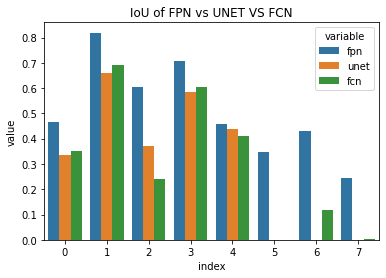

In [16]:
# result for FPN
result_fpn = [
    0.46724114,
    0.8189325,
    0.6044639,
    0.7086379,
    0.45720816,
    0.34781703,
    0.42935002,
    0.24366052,
]

# result for UNET
result_unet = [
    3.3367285e-01,
    6.6008663e-01,
    3.7074447e-01,
    5.8561021e-01,
    4.3773600e-01,
    0.0000000e00,
    7.9385777e-20,
    1.1507687e-23,
]

result_fcn = [
    0.3529532,
    0.6904841,
    0.23908164,
    0.6038181,
    0.4120346,
    0.0,
    0.11895951,
    0.00323856,
]


results = pd.DataFrame(
    {"fpn": result_fpn, "unet": result_unet, "fcn": result_fcn},
)

results = results.melt()
results["index"] = [i % 8 for i in range(24)]
fig, ax = plt.subplots()

ax.set_title("IoU of FPN vs UNET VS FCN")
sb.barplot(data=results, x="index", y="value", hue="variable") ;


In [2]:
num = 0
total_iou = 0
classes_iou = tf.zeros([8])

for d, y in test.take(1):
    # add 8 padding horizontally
    # d = sm.get_preprocessing('resnet50')(d)
    d = tf.pad(d, [[0, 0], [8, 8], [0, 0], [0, 0]])
    y = tf.pad(y, [[0, 0], [8, 8], [0, 0], [0, 0]])
    # add thresholding to make image sharper
    out_img = tf.cast(model(d, training=False), tf.float32)

    fig, axs = plt.subplots(8, 4, figsize=(20, 20))
    for i in range(8):
        axs[i, 0].imshow(
            (d[0, :, :, :] / 255.0)
            * tf.repeat(y[0, :, :, i][..., tf.newaxis], 3, axis=-1)
        )  # this is the AND of image and target mask
        axs[i, 1].imshow(y[0, :, :, i])  # this is the target mask
        axs[i, 2].imshow(
            (d[0, :, :, :] / 255.0)
            * tf.repeat(out_img[0, :, :, i][..., tf.newaxis], 3, axis=-1)
        )  # this is the AND of image and predicted mask
        axs[i, 3].imshow(out_img[0, :, :, i])  # this is the predicted mask

    num += 1
    classes_iou += JINDEX(y, out_img)
print(classes_iou / num)

NameError: name 'tf' is not defined

In [13]:
def to_save(images, name):
    for idx in range(images[0].shape[-1]):
        byte = tf.image.encode_jpeg(
            tf.image.convert_image_dtype(images[0, ..., idx][..., tf.newaxis], tf.uint8)
        )
        tf.io.write_file(f"{name}_{idx}_image.jpeg", byte)


def to_save_mask(images, mask, name):
    for idx in range(mask[0].shape[-1]):
        thismask = tf.repeat(mask[0, ..., idx][..., tf.newaxis], 3, axis=-1)
        image = images[0] * thismask
        byte = tf.image.encode_jpeg(
            tf.image.convert_image_dtype(image / 255.0, tf.uint8)
        )
        tf.io.write_file(f"{name}_{idx}_image.jpeg", byte)


# to_save_mask(d, y, "target")
# to_save_mask(d, out_img, "mask")